In [2]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.108.205.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.205.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [3]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
# 패키지 로드
import pandas as pd                        
import numpy as np                         
import datetime as dt

# # 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 정규화, 표준화
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

# 군집화
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# 선형회귀
# from sklearn.linear_model import LinearRegression

# 결정트리
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# RandomForest
from sklearn.ensemble import RandomForestRegressor

# lightgbm
# import lightgbm

# tensor
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dtypes = {"id":"int32", "breath_id":"int32","R":"int8","C":"int8","u_out":"category"}

train_df = pd.read_csv("/content/drive/MyDrive/ventilator_data/train.csv", dtype = dtypes)
test_df = pd.read_csv("/content/drive/MyDrive/ventilator_data/test.csv", dtype = dtypes)

In [13]:
train = train_df.copy()
test = test_df.copy()

## Feature Engineering

### 특성공학 함수

In [38]:
def feature_engineering(df):

    # u_in이 0인 값의 개수
    df['u_in_zeros'] = df[df["u_in"]==0].groupby("breath_id")["u_in"].count()

    # u_in shift
    df['u_in_prev1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_prev2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_in_prev3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_in_next1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_in_next2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_in_next3'] = df.groupby('breath_id')['u_in'].shift(-3)

    df['u_in_prev1'] = df['u_in_prev1'].bfill()
    df['u_in_prev2'] = df['u_in_prev2'].bfill()
    df['u_in_prev3'] = df['u_in_prev3'].bfill()
    df['u_in_next1'] = df['u_in_next1'].ffill()
    df['u_in_next2'] = df['u_in_next2'].ffill()
    df['u_in_next3'] = df['u_in_next3'].ffill()
    
    # u_in 분산
    df['u_in_volatility_prev1'] = (df['u_in'] - df['u_in_prev1']) ** 2
    df['u_in_volatility_prev2'] = (df['u_in'] - df['u_in_prev2']) ** 2
    df['u_in_volatility_prev3'] = (df['u_in'] - df['u_in_prev3']) ** 2
    df['u_in_volatility_next1'] = (df['u_in'] - df['u_in_next1']) ** 2
    df['u_in_volatility_next2'] = (df['u_in'] - df['u_in_next2']) ** 2
    df['u_in_volatility_next3'] = (df['u_in'] - df['u_in_next3']) ** 2

    # 흡입된 공기의 총량
    df["u_in_cumsum"] = df.groupby("breath_id").cumsum()["u_in"]
    
    # 흡입된 공기량의 구간
    maximum = df.groupby("breath_id")["u_in"].transform("max")
    df["maximum_in_band"] = pd.qcut(maximum, 5,labels=[0,1,2,3,4])
    
    # 흡입된 공기량의 증가량
    df["percentage_change"] = df["u_in"] / maximum
    df["percentage_change"] = df["percentage_change"].fillna(0) # u_in이 0인 값들이 있기 때문에 진행

    # 시작 지점의 u_in 값 => 구간으로
    u_in_start = df.groupby("breath_id")["u_in"].transform("first")
    df["first_in"] = pd.qcut(u_in_start,4, duplicates="drop", labels=[0,1,2])
    
    # R_C
    df["R_C"] = df["R"].astype(str) + "_" + df["C"].astype(str) 
    
    # 패턴 클러스터링
    # cluster_df = pd.read_csv("data/pattern_200.bz2", dtype={"pattern":"category"})

    # df = pd.merge(df,cluster_df)

    # id, breath_id 제거
    df = df.drop(["id","breath_id"],axis=1)
    df = pd.get_dummies(df, columns=["R_C","maximum_in_band","first_in"])
    
    return df

In [39]:
train = feature_engineering(train)

In [40]:
test = feature_engineering(test)

In [42]:
train["u_in_zeros"]

0           NaN
1          15.0
2          15.0
3          16.0
4          16.0
           ... 
6035995     NaN
6035996     NaN
6035997     NaN
6035998     NaN
6035999     NaN
Name: u_in_zeros, Length: 6036000, dtype: float64

In [55]:
train[train["u_in"]==0].groupby("breath_id")[]

id   R   C  time_step  u_in  u_out  pressure
30       15  15  15         15    15     15        15
31       15  15  15         15    15     15        15
32       15  15  15         15    15     15        15
33       15  15  15         15    15     15        15
34       15  15  15         15    15     15        15
...      ..  ..  ..        ...   ...    ...       ...
6035885  16  16  16         16    16     16        16
6035886  16  16  16         16    16     16        16
6035951   3   3   3          3     3      3         3
6035965   3   3   3          3     3      3         3
6035967   3   3   3          3     3      3         3

[1432253 rows x 7 columns]

### pattern 시각화

In [ ]:
con_scaled = MinMaxScaler().fit_transform(train["u_in"].values.reshape(-1,1))

In [ ]:
con_reshaped = con_scaled.reshape(-1,80)

In [ ]:
pred = train.groupby("breath_id").first()["pattern"]

In [ ]:
pred = pred.values
pred

['81', '15', '49', '198', '41', ..., '1', '45', '15', '149', '60']
Length: 75450
Categories (200, object): ['0', '1', '10', '100', ..., '96', '97', '98', '99']

In [ ]:
ex_df = pd.concat([pd.DataFrame(con_reshaped),pd.DataFrame(pred,columns=["pattern"])],axis=1)
ex_df

0         1         2         3         4         5         6  \
0      0.000833  0.183830  0.225093  0.228088  0.253559  0.272599  0.271275   
1      0.121843  0.139802  0.125742  0.117305  0.121242  0.110556  0.107744   
2      0.000000  0.071872  0.133388  0.171113  0.183540  0.174177  0.153531   
3      0.000000  0.012625  0.040014  0.063794  0.082952  0.097904  0.108744   
4      0.214244  0.285047  0.293530  0.305021  0.310246  0.322247  0.323648   
...         ...       ...       ...       ...       ...       ...       ...   
75445  0.000000  0.000000  0.006739  0.017008  0.026199  0.033972  0.040304   
75446  0.856302  1.000000  0.815668  0.000000  0.233284  0.898197  0.000000   
75447  0.000000  0.000000  0.000000  0.009502  0.032567  0.046781  0.046287   
75448  0.155642  0.235888  0.202987  0.123264  0.108079  0.116304  0.109977   
75449  0.060306  0.255042  0.216147  0.162667  0.161012  0.147001  0.131177   

              7         8         9  ...        71        72        73  \
0      0.268077  0.278647  0.283130  ...  0.049496  0.049575  0.049641   
1      0.111119  0.100995  0.100433  ...  0.049551  0.049622  0.049681   
2      0.136419  0.123368  0.114871  ...  0.048944  0.049100  0.049233   
3      0.133365  0.159982  0.182940  ...  0.048978  0.049128  0.049256   
4      0.328583  0.325518  0.340313  ...  0.049616  0.049677  0.049727   
...         ...       ...       ...  ...       ...       ...       ...   
75445  0.045401  0.048277  0.051231  ...  0.049590  0.049654  0.049710   
75446  0.000000  0.607196  0.195957  ...  0.049468  0.049551  0.049621   
75447  0.049701  0.053021  0.042364  ...  0.049458  0.049542  0.049613   
75448  0.095425  0.109345  0.109977  ...  0.048957  0.049110  0.049241   
75449  0.135739  0.119533  0.102968  ...  0.013623  0.013576  0.013532   

             74        75        76        77        78        79  pattern  
0      0.049697  0.049745  0.049785  0.049818  0.049847  0.049871       81  
1      0.049731  0.049773  0.049809  0.049839  0.049864  0.049885       15  
2      0.049346  0.049443  0.049525  0.049595  0.049655  0.049706       49  
3      0.049365  0.049461  0.049540  0.049608  0.049665  0.049716      198  
4      0.049771  0.049807  0.049838  0.049864  0.049885  0.049903       41  
...         ...       ...       ...       ...       ...       ...      ...  
75445  0.049755  0.049794  0.049827  0.049854  0.049877  0.049897        1  
75446  0.049679  0.049729  0.049771  0.049807  0.049837  0.049862       45  
75447  0.049674  0.049724  0.049767  0.049804  0.049834  0.049860       15  
75448  0.049353  0.049448  0.049529  0.049598  0.049657  0.049707      149  
75449  0.014207  0.014897  0.014885  0.015590  0.012727  0.014827       60  

[75450 rows x 81 columns]

In [ ]:
ex_df = pd.concat([ex_df,pd.DataFrame(train["breath_id"].unique(),columns=["breath_id"])],axis=1)
ex_df

0         1         2         3         4         5         6  \
0      0.000833  0.183830  0.225093  0.228088  0.253559  0.272599  0.271275   
1      0.121843  0.139802  0.125742  0.117305  0.121242  0.110556  0.107744   
2      0.000000  0.071872  0.133388  0.171113  0.183540  0.174177  0.153531   
3      0.000000  0.012625  0.040014  0.063794  0.082952  0.097904  0.108744   
4      0.214244  0.285047  0.293530  0.305021  0.310246  0.322247  0.323648   
...         ...       ...       ...       ...       ...       ...       ...   
75445  0.000000  0.000000  0.006739  0.017008  0.026199  0.033972  0.040304   
75446  0.856302  1.000000  0.815668  0.000000  0.233284  0.898197  0.000000   
75447  0.000000  0.000000  0.000000  0.009502  0.032567  0.046781  0.046287   
75448  0.155642  0.235888  0.202987  0.123264  0.108079  0.116304  0.109977   
75449  0.060306  0.255042  0.216147  0.162667  0.161012  0.147001  0.131177   

              7         8         9  ...        72        73        74  \
0      0.268077  0.278647  0.283130  ...  0.049575  0.049641  0.049697   
1      0.111119  0.100995  0.100433  ...  0.049622  0.049681  0.049731   
2      0.136419  0.123368  0.114871  ...  0.049100  0.049233  0.049346   
3      0.133365  0.159982  0.182940  ...  0.049128  0.049256  0.049365   
4      0.328583  0.325518  0.340313  ...  0.049677  0.049727  0.049771   
...         ...       ...       ...  ...       ...       ...       ...   
75445  0.045401  0.048277  0.051231  ...  0.049654  0.049710  0.049755   
75446  0.000000  0.607196  0.195957  ...  0.049551  0.049621  0.049679   
75447  0.049701  0.053021  0.042364  ...  0.049542  0.049613  0.049674   
75448  0.095425  0.109345  0.109977  ...  0.049110  0.049241  0.049353   
75449  0.135739  0.119533  0.102968  ...  0.013576  0.013532  0.014207   

             75        76        77        78        79  pattern  breath_id  
0      0.049745  0.049785  0.049818  0.049847  0.049871       81          1  
1      0.049773  0.049809  0.049839  0.049864  0.049885       15          2  
2      0.049443  0.049525  0.049595  0.049655  0.049706       49          3  
3      0.049461  0.049540  0.049608  0.049665  0.049716      198          4  
4      0.049807  0.049838  0.049864  0.049885  0.049903       41          5  
...         ...       ...       ...       ...       ...      ...        ...  
75445  0.049794  0.049827  0.049854  0.049877  0.049897        1     125740  
75446  0.049729  0.049771  0.049807  0.049837  0.049862       45     125742  
75447  0.049724  0.049767  0.049804  0.049834  0.049860       15     125743  
75448  0.049448  0.049529  0.049598  0.049657  0.049707      149     125745  
75449  0.014897  0.014885  0.015590  0.012727  0.014827       60     125749  

[75450 rows x 82 columns]

In [ ]:
ex_df["pattern"].unique()

['81', '15', '49', '198', '41', ..., '168', '135', '192', '127', '113']
Length: 200
Categories (200, object): ['81', '15', '49', '198', ..., '135', '192', '127', '113']

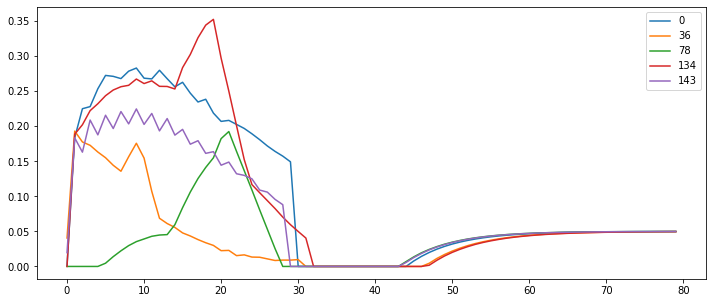

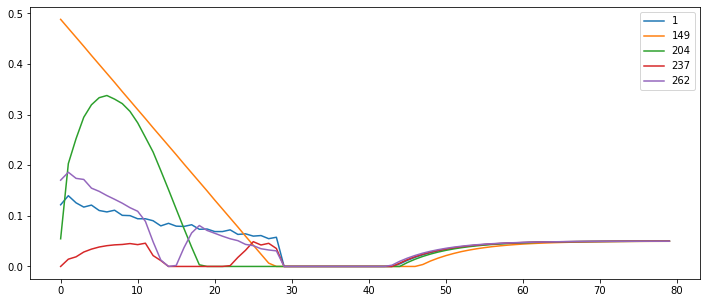

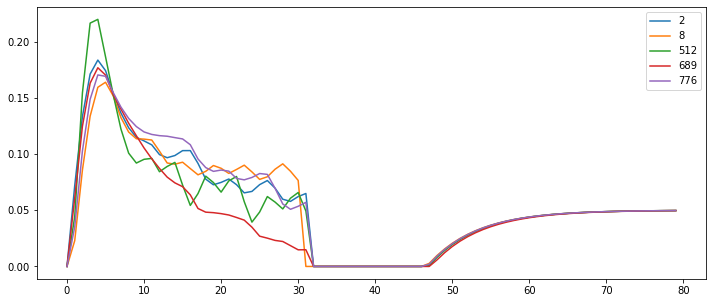

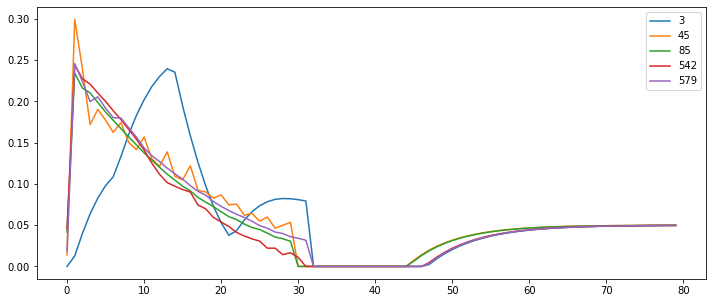

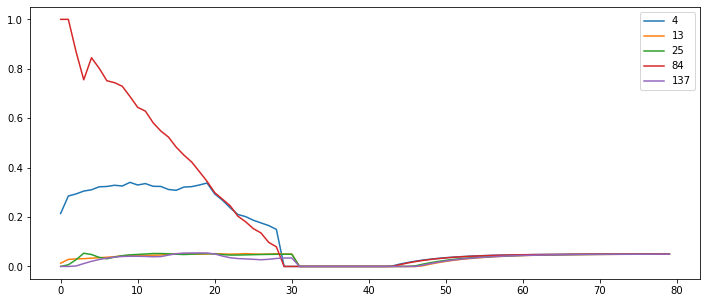

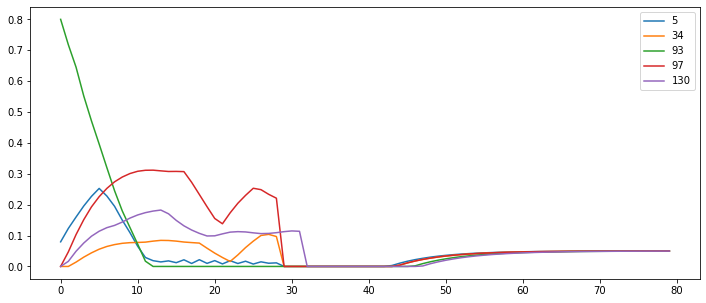

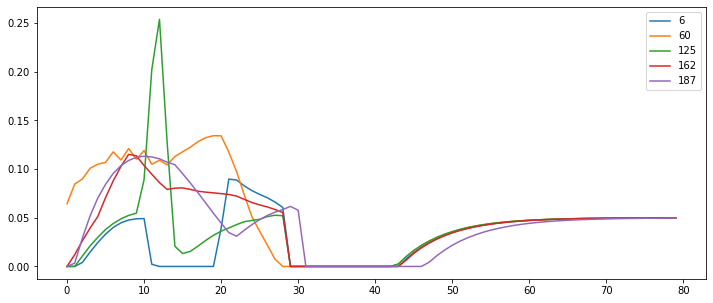

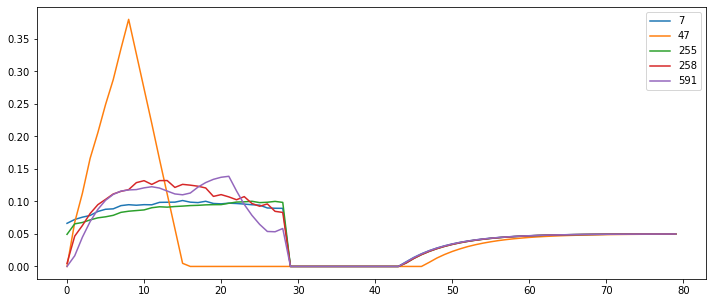

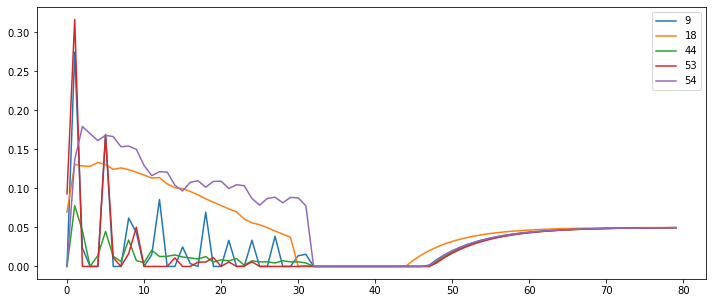

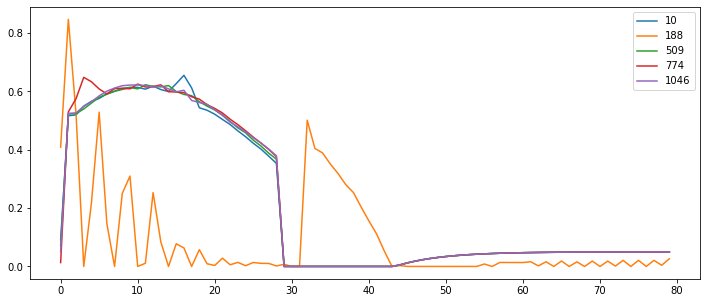

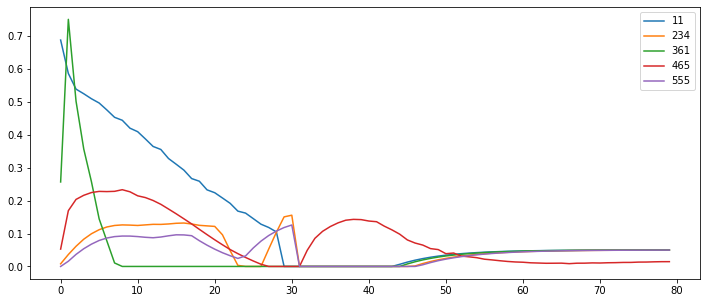

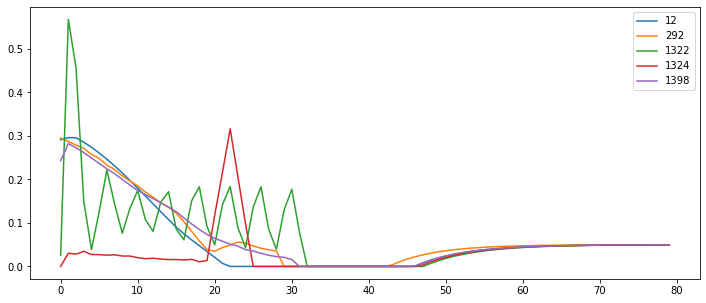

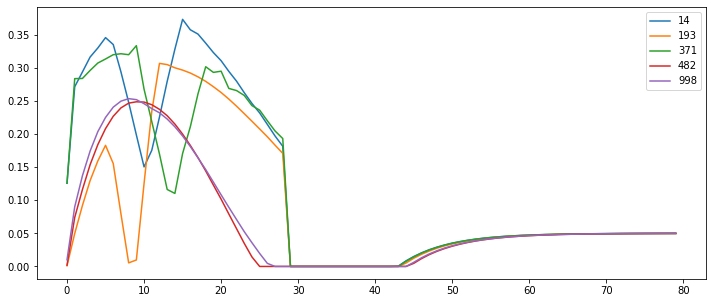

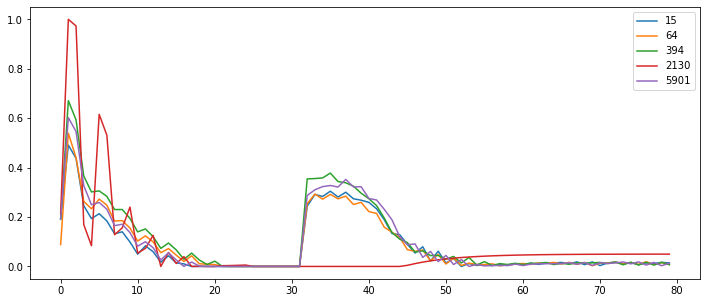

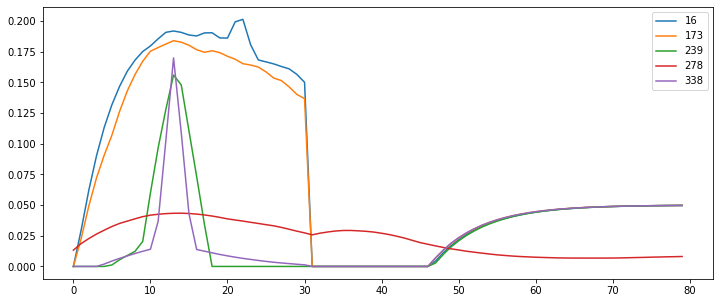

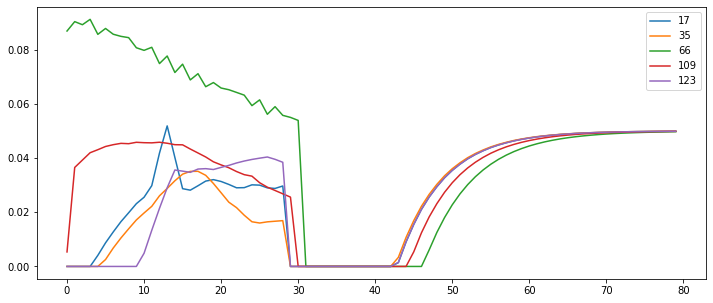

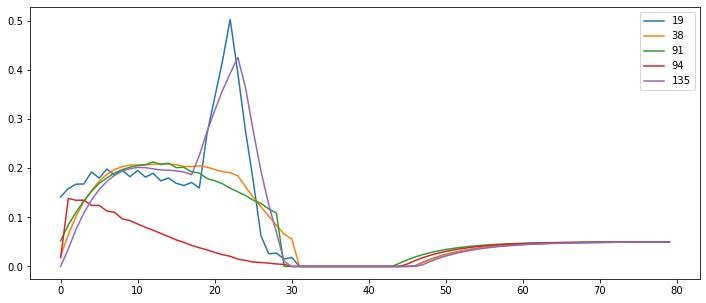

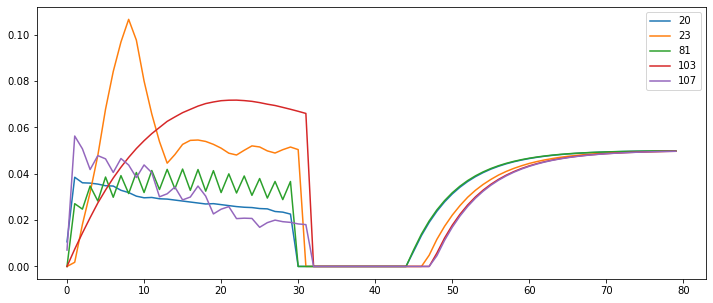

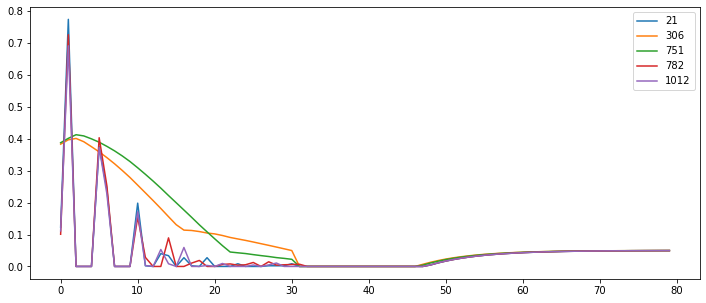

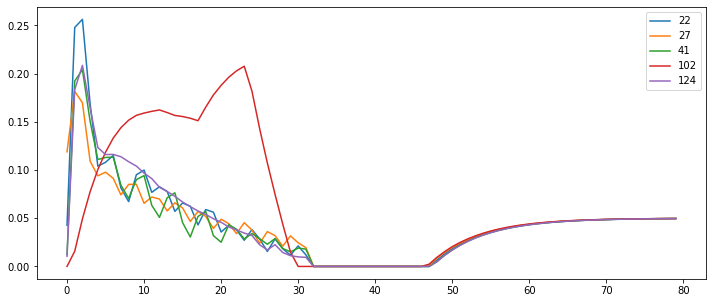

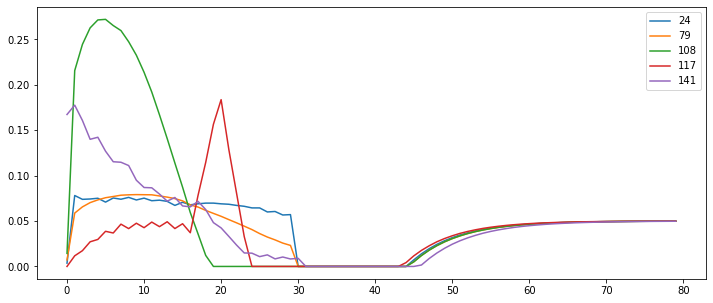

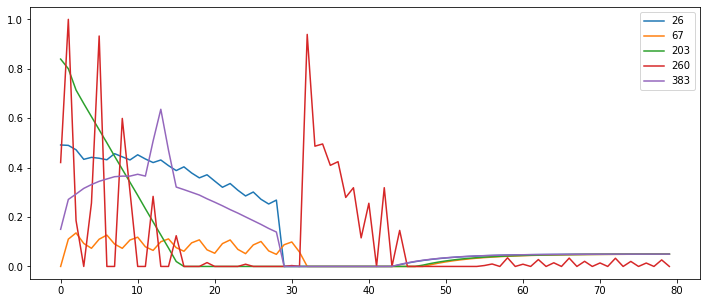

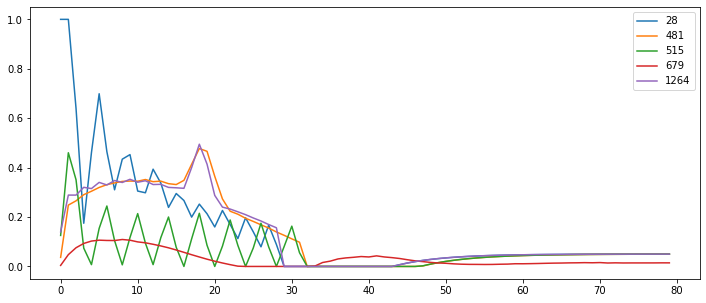

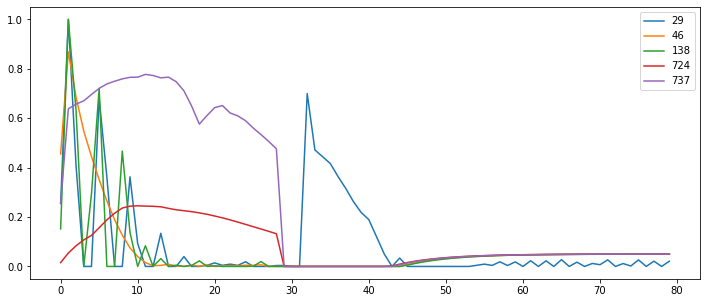

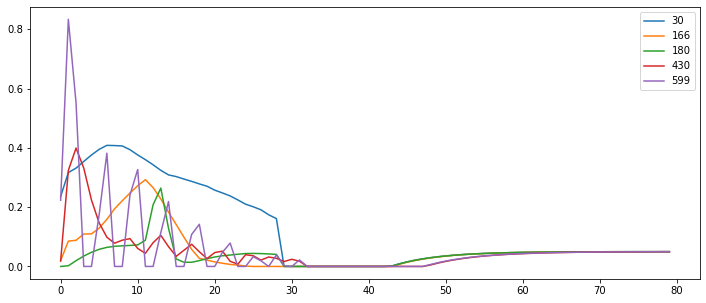

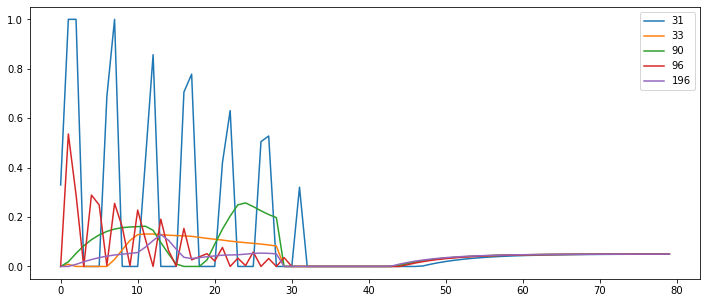

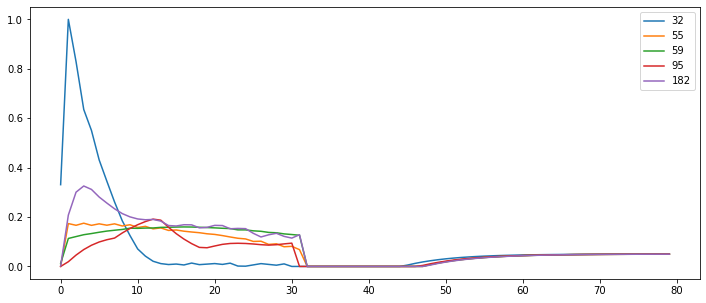

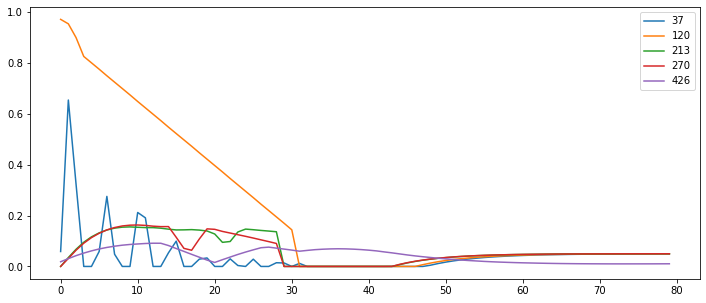

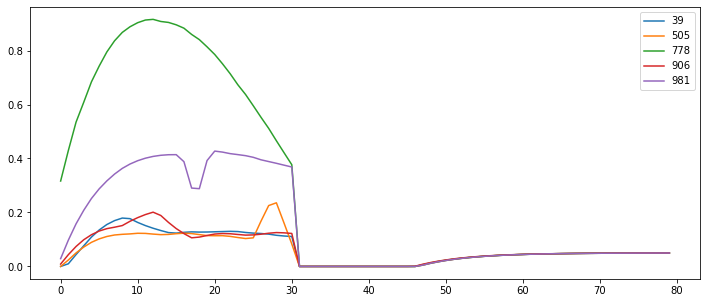

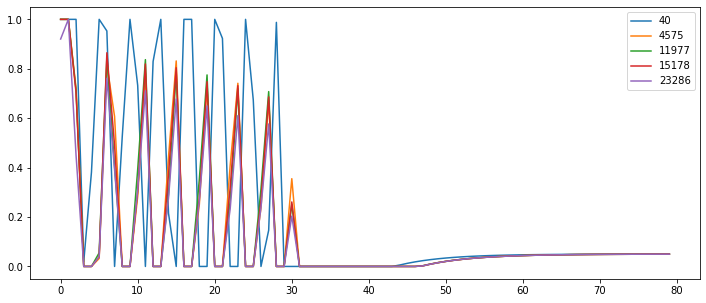

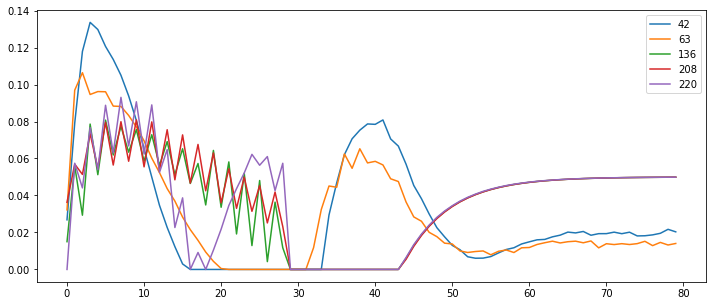

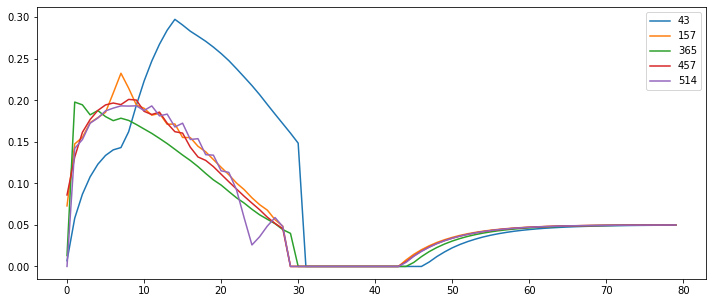

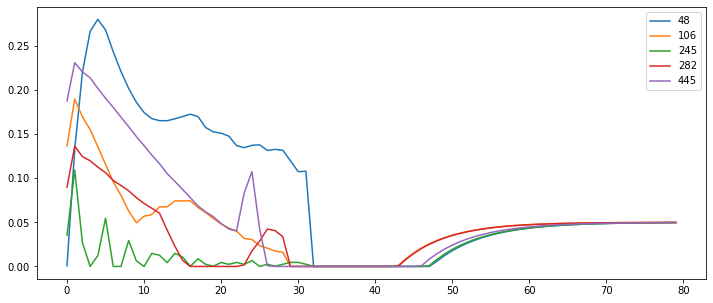

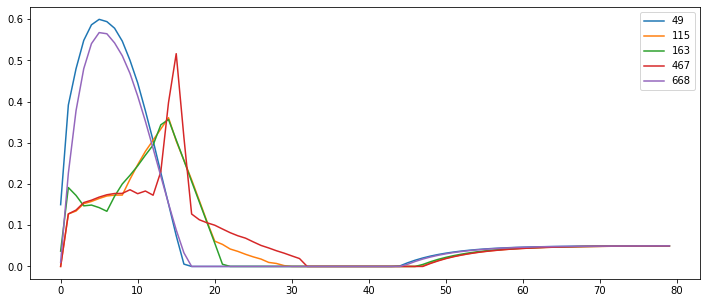

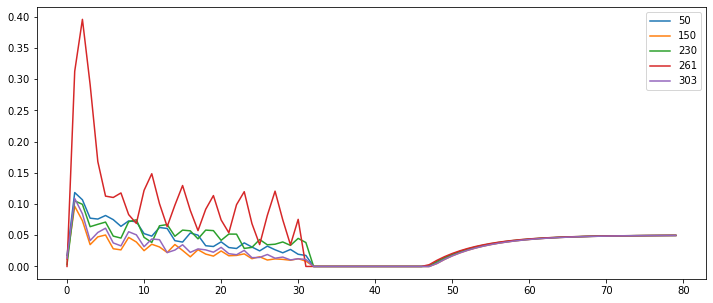

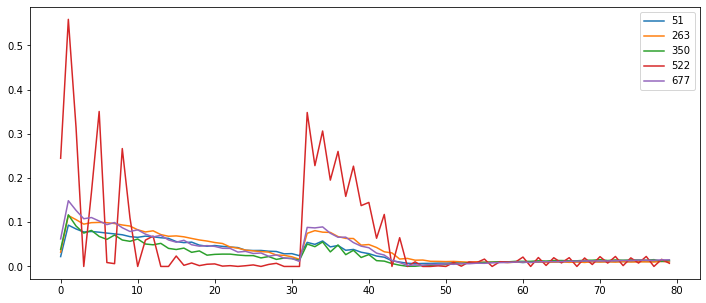

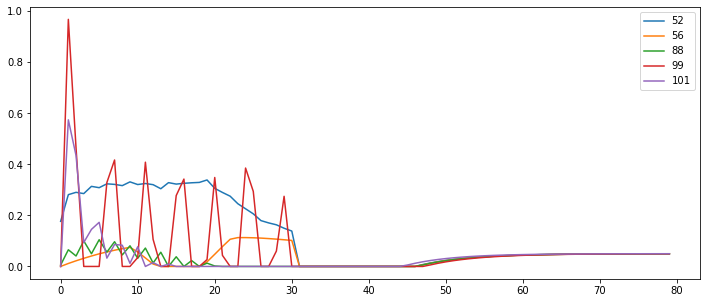

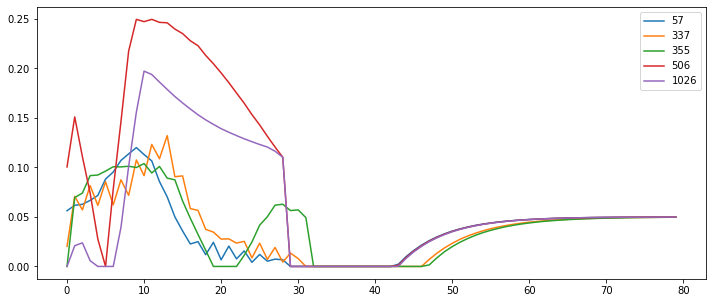

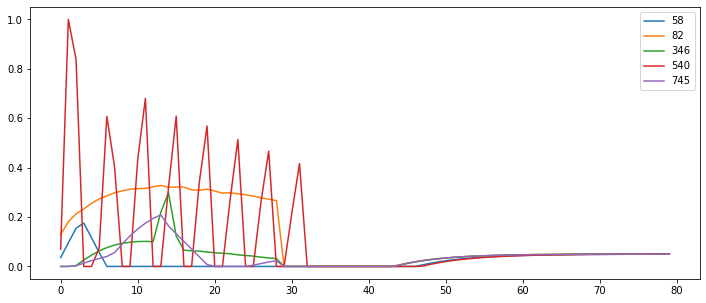

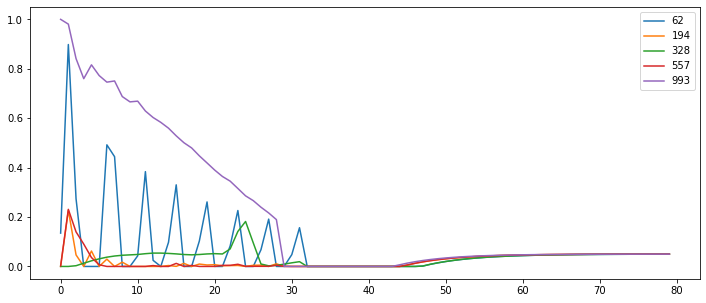

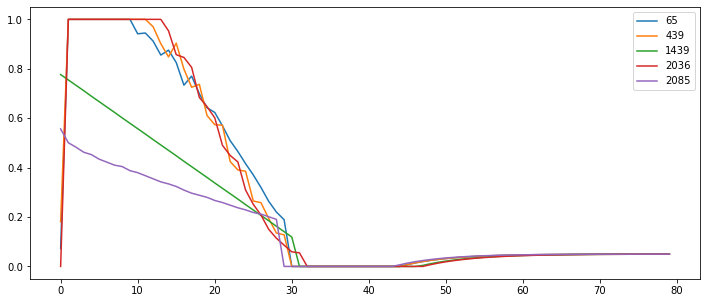

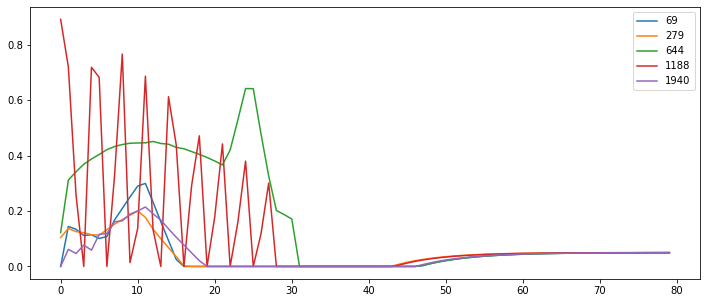

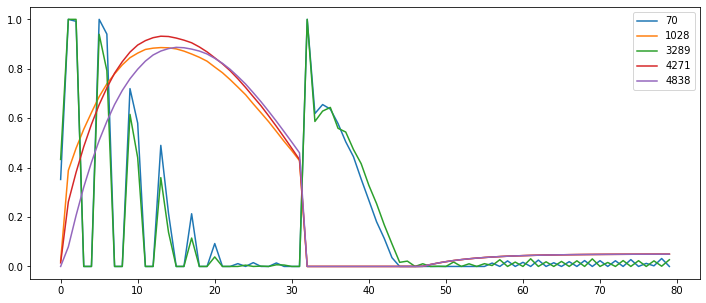

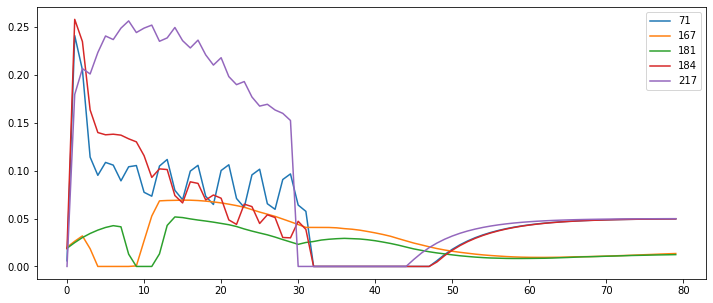

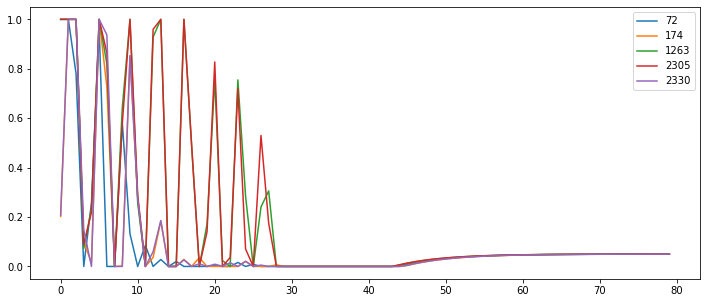

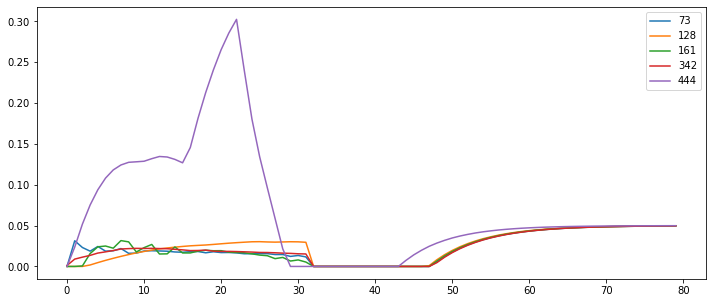

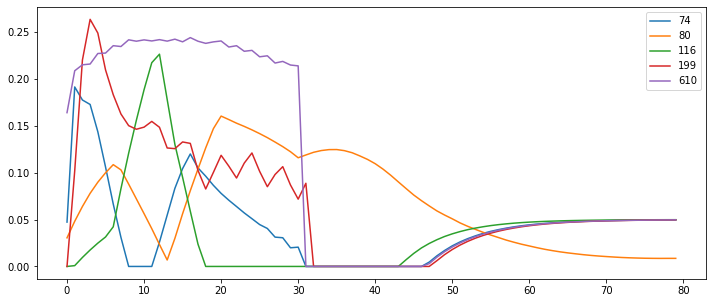

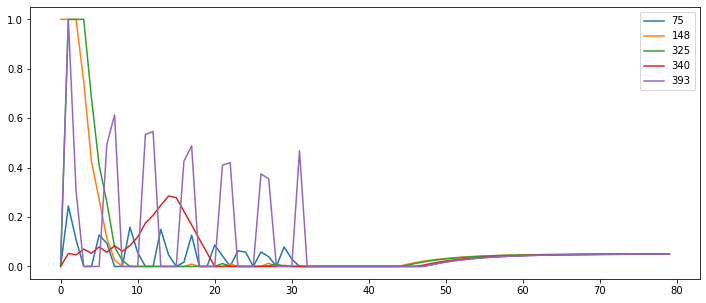

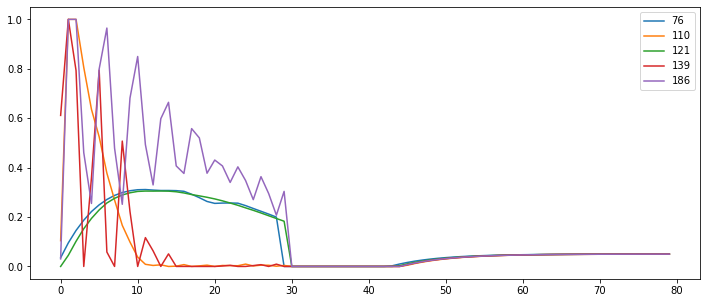

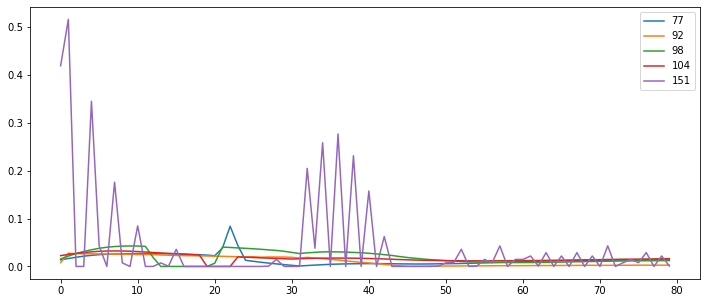

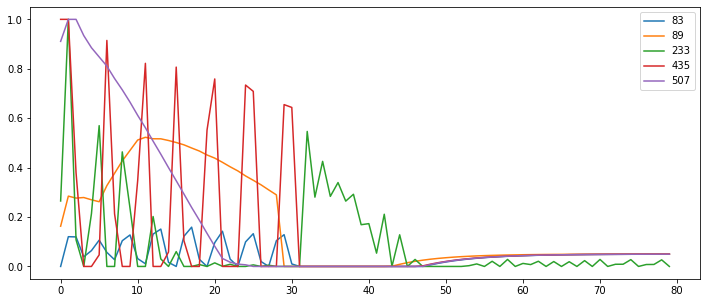

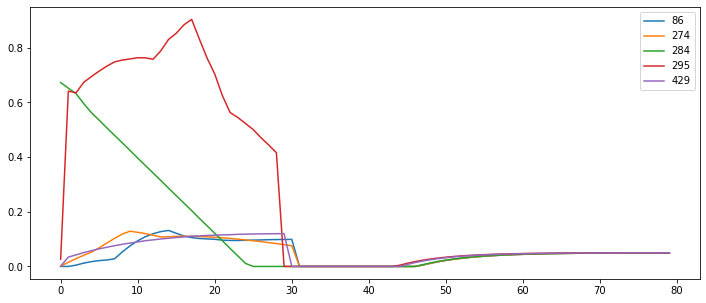

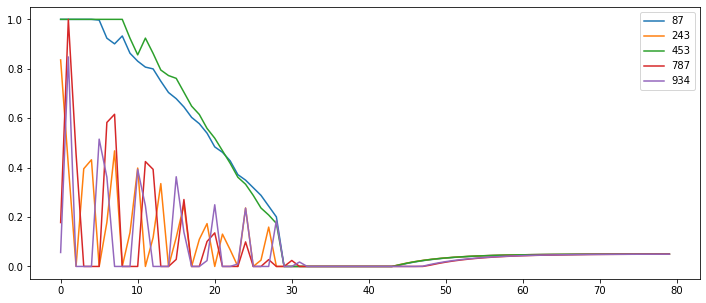

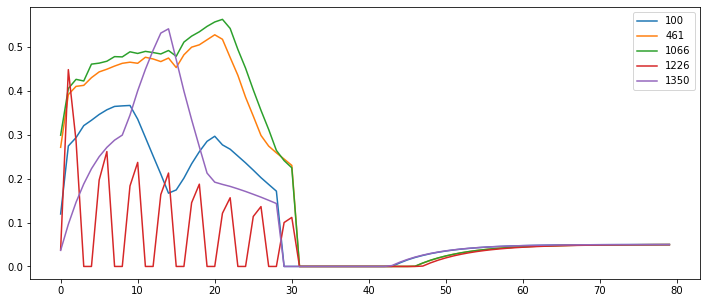

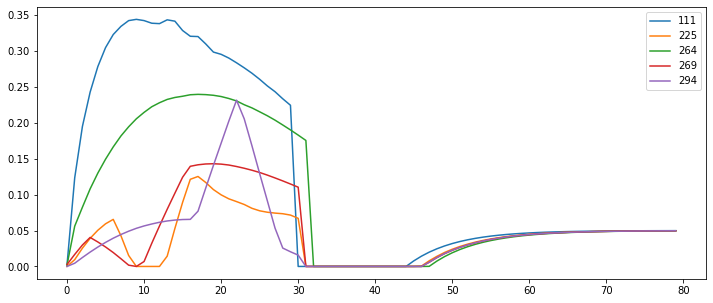

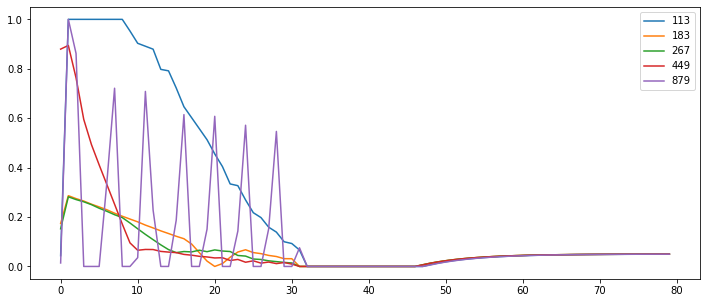

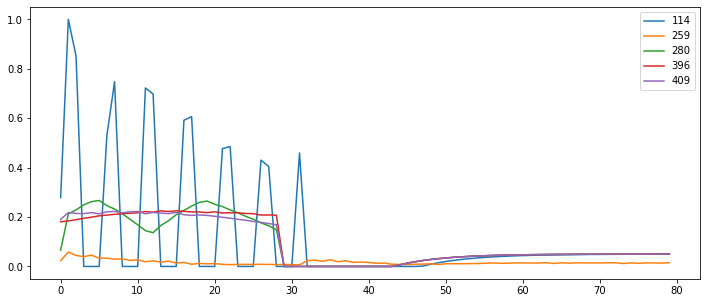

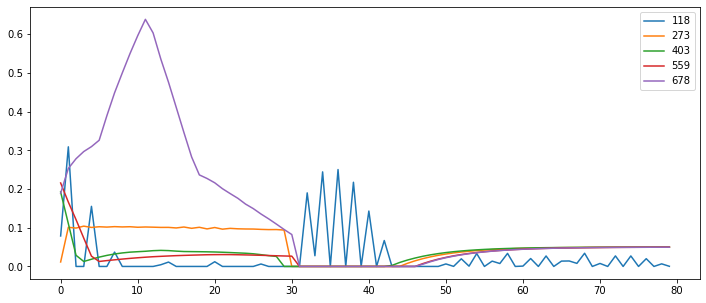

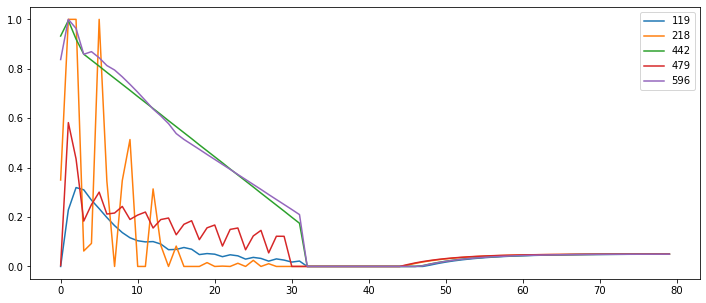

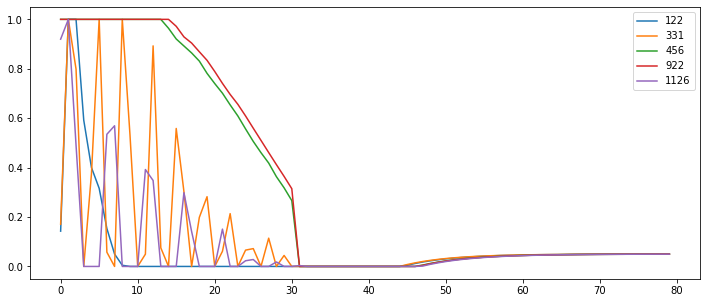

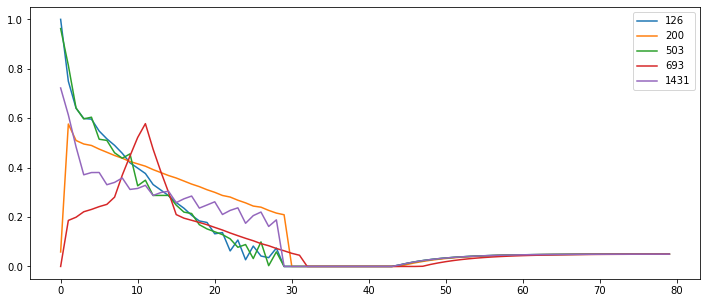

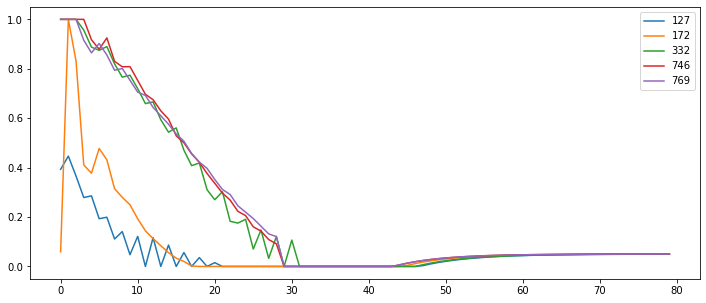

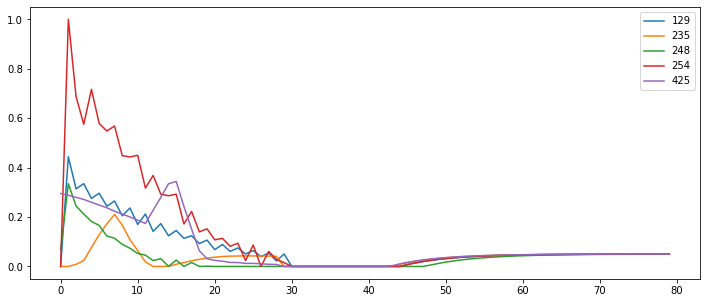

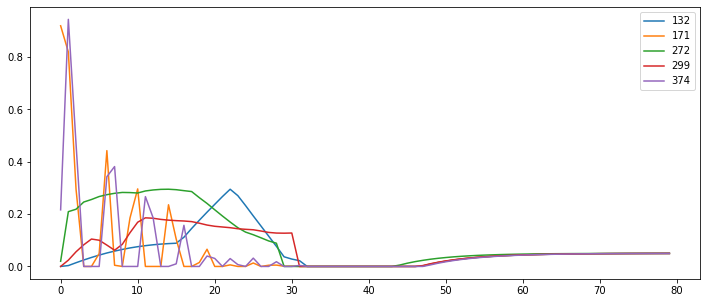

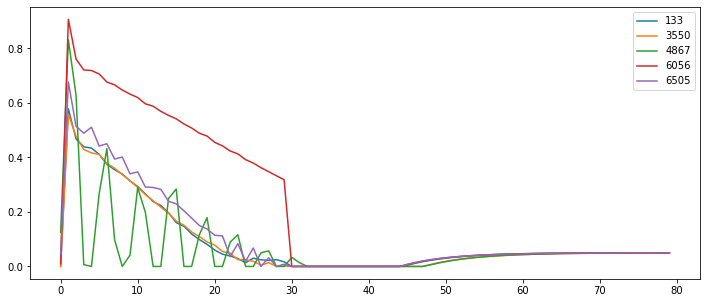

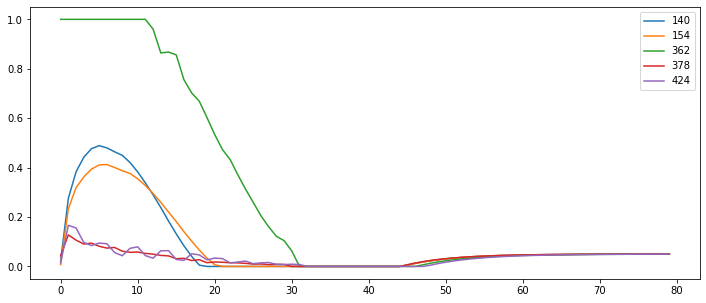

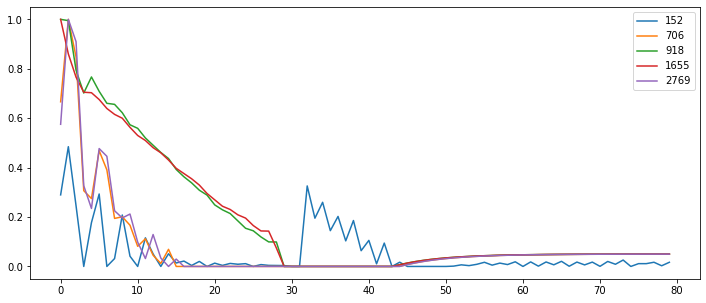

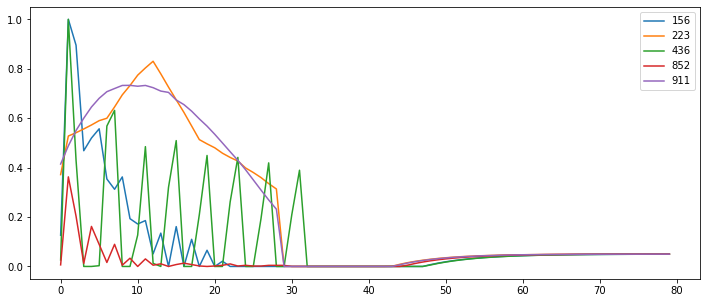

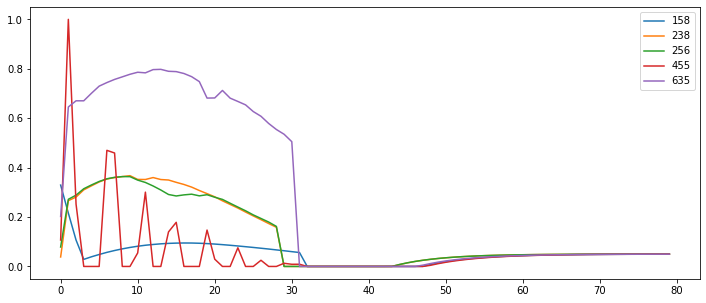

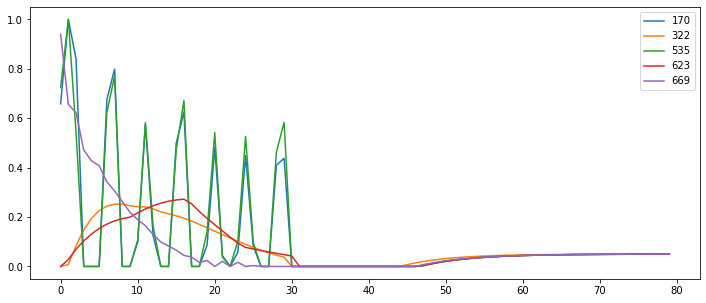

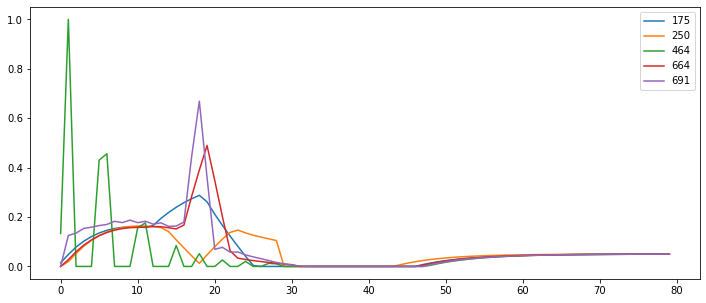

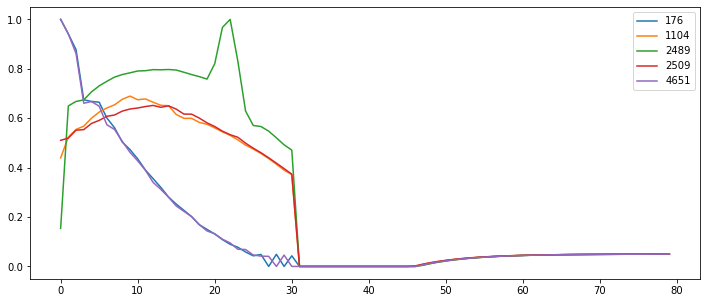

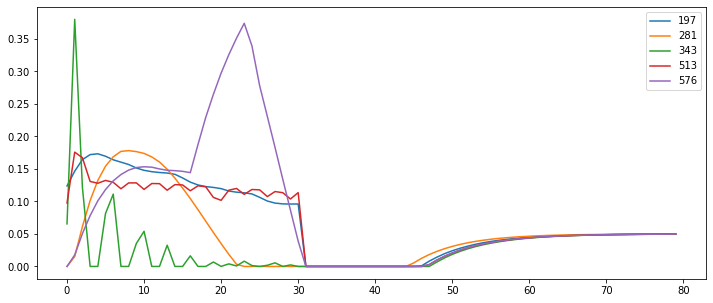

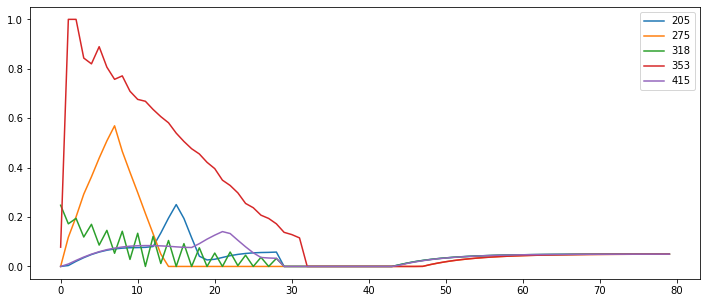

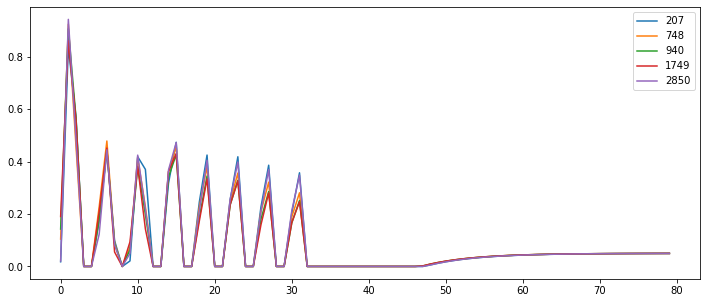

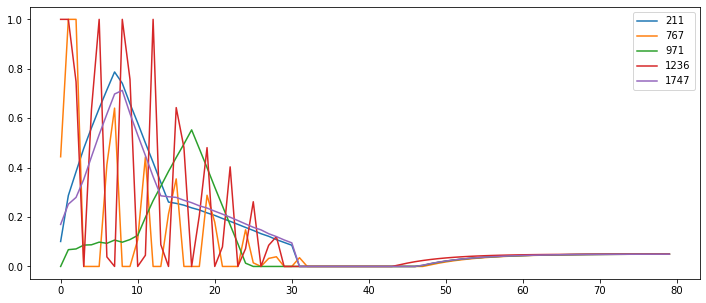

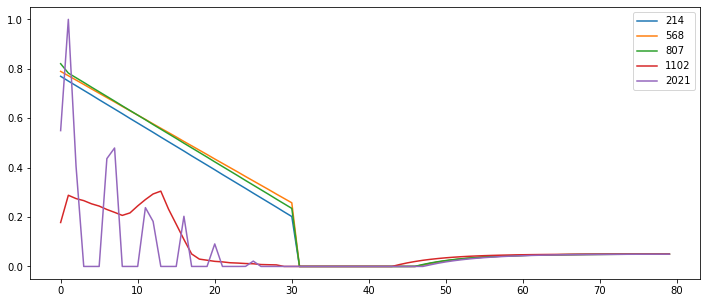

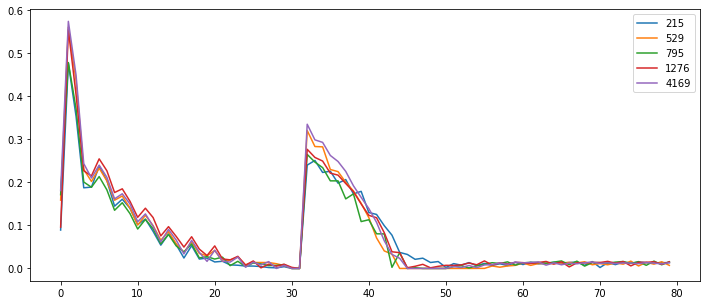

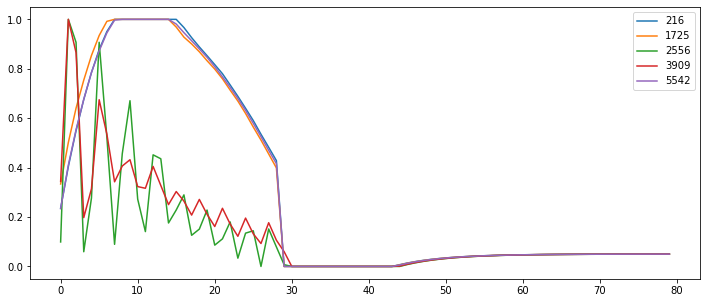

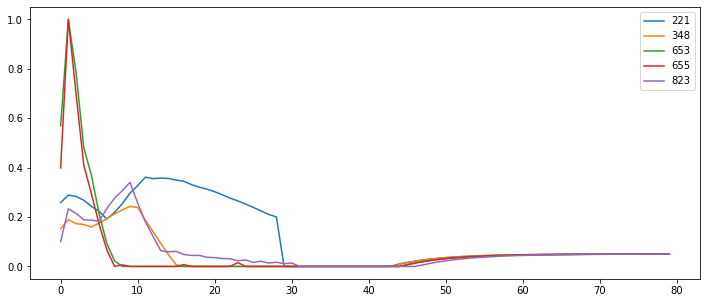

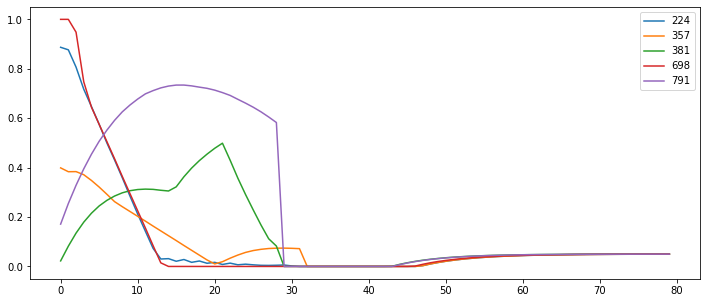

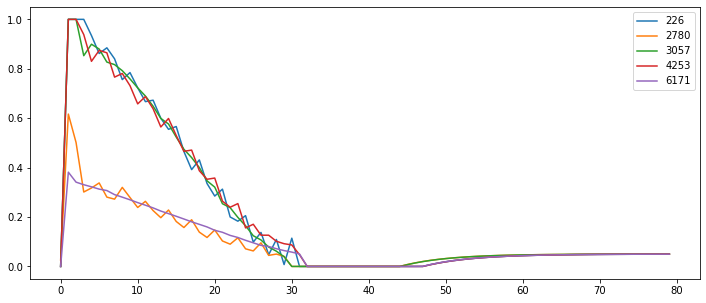

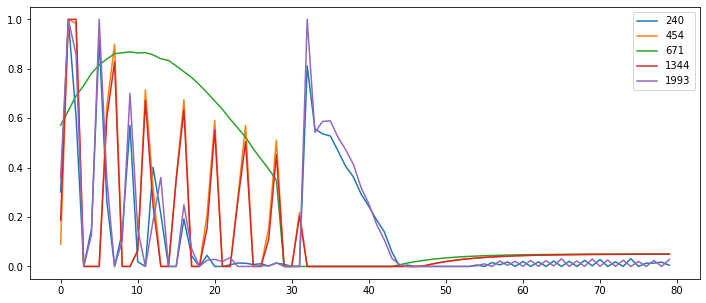

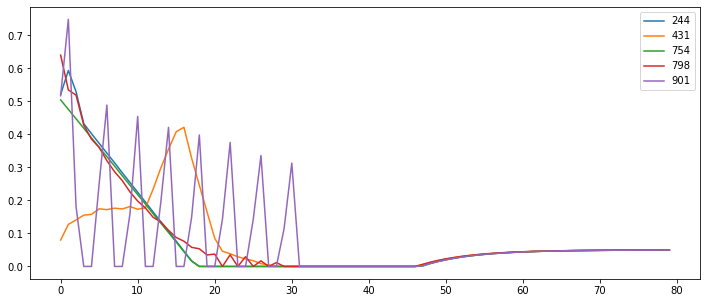

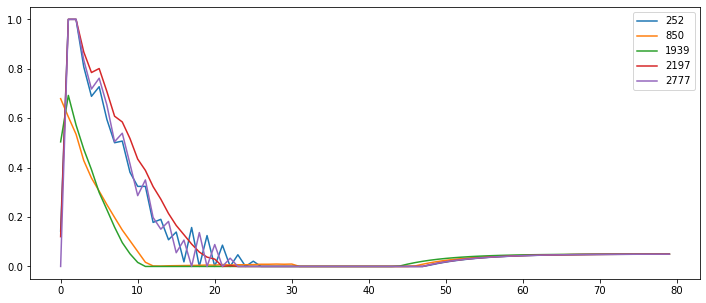

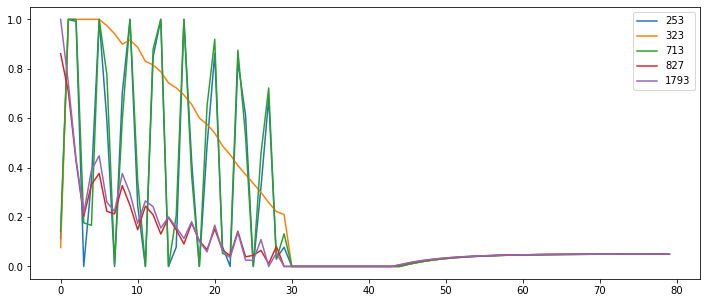

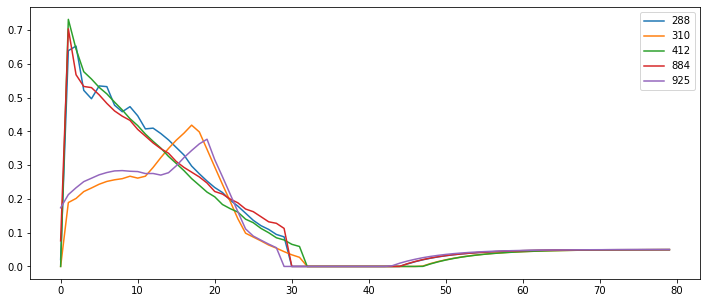

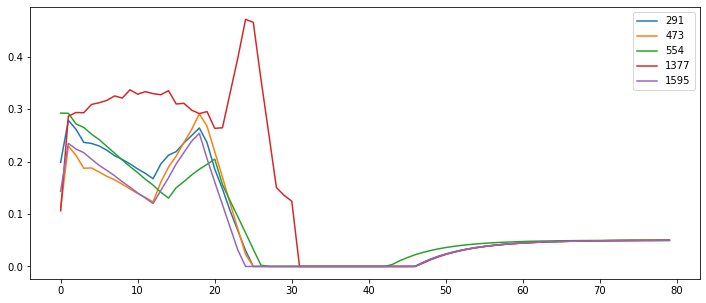

KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(16,6))
for pat in ex_df["pattern"].unique():
    plt.figure(figsize=(12,5))
    for j in range(5):
        ex_df[ex_df["pattern"]==pat].iloc[j,:-2].plot()
    
    plt.legend()
    plt.show()

In [ ]:
ex_df[ex_df["breath_id"]==188]

0         1         2         3         4         5         6  \
133  0.0  0.578482  0.467601  0.438864  0.434284  0.411234  0.375182   

            7         8         9  ...       72        73        74        75  \
133  0.354832  0.339156  0.313872  ...  0.04952  0.049595  0.049657  0.049711   

           76        77        78        79  pattern  breath_id  
133  0.049756  0.049794  0.049826  0.049853      137        188  

[1 rows x 82 columns]

In [ ]:
a= train[train["pattern"]=="137"]["u_in"].values.reshape(-1,80)
len(a)

112

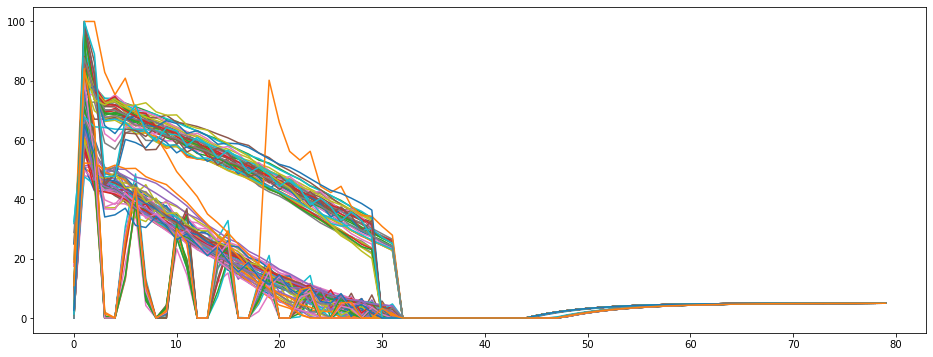

In [ ]:
plt.figure(figsize=(16,6))
for i in a:
    plt.plot(i)

In [ ]:
ex_df["pattern"].unique()

### 시작 지점의 u_in 값

In [ ]:
train[train["time_step"]==0]["u_in"]

0           0.083334
80         12.184338
160         0.000000
240         0.000000
320        21.424375
             ...    
6035600     0.000000
6035680    85.630231
6035760     0.000000
6035840    15.564236
6035920     6.030572
Name: u_in, Length: 75450, dtype: float64

In [ ]:
u_in_start.describe()

count    75450.000000
mean        13.910675
std         25.137113
min          0.000000
25%          0.000000
50%          2.027507
75%         14.088825
max        100.000000
Name: u_in, dtype: float64

### u_in이 0인 구간 

In [11]:
train['u_in_first_iszero'] = train[train['u_in'] == 0].groupby('breath_id')['u_in'].transform('count')

In [12]:
train["u_in_first_iszero"]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
6035995   NaN
6035996   NaN
6035997   NaN
6035998   NaN
6035999   NaN
Name: u_in_first_iszero, Length: 6036000, dtype: float64

In [20]:
u_in_first_s = train[train["u_in"]==0].groupby("breath_id")["u_in"].count()

In [22]:
u_in_first_s

breath_id
1         15
2         15
3         16
4         16
5         14
          ..
125740    21
125742    31
125743    32
125745    16
125749     3
Name: u_in, Length: 73645, dtype: int64

In [29]:
train[train["u_in"]==0].groupby("breath_id")["u_in"].count()

breath_id
1         15
2         15
3         16
4         16
5         14
          ..
125740    21
125742    31
125743    32
125745    16
125749     3
Name: u_in, Length: 73645, dtype: int64

In [27]:
train["breath_id"].nunique()-73645

1805

In [23]:
train[train["u_in"]==0]

id  breath_id   R   C  ...  u_in  u_out   pressure  u_in_first_iszero
30            31          1  20  50  ...   0.0      1  19.546410               15.0
31            32          1  20  50  ...   0.0      1  17.015533               15.0
32            33          1  20  50  ...   0.0      1   9.563505               15.0
33            34          1  20  50  ...   0.0      1   7.876254               15.0
34            35          1  20  50  ...   0.0      1   8.649578               15.0
...          ...        ...  ..  ..  ...   ...    ...        ...                ...
6035885  6035886     125745  50  50  ...   0.0      1   7.032628               16.0
6035886  6035887     125745  50  50  ...   0.0      1   6.470211               16.0
6035951  6035952     125749  50  10  ...   0.0      1  29.459013                3.0
6035965  6035966     125749  50  10  ...   0.0      1   6.681117                3.0
6035967  6035968     125749  50  10  ...   0.0      1   6.118700                3.0

[1432253 rows x 9 columns]

### R_C

In [ ]:
train["R_C"] = train["R"].astype(str)+"_"+train["C"].astype(str)

In [ ]:
pd.get_dummies(train, columns=["R_C"])

id  breath_id   R   C  time_step       u_in u_out   pressure  \
0              1          1  20  50   0.000000   0.083334     0   5.837492   
1              2          1  20  50   0.033652  18.383041     0   5.907794   
2              3          1  20  50   0.067514  22.509278     0   7.876254   
3              4          1  20  50   0.101542  22.808822     0  11.742872   
4              5          1  20  50   0.135756  25.355850     0  12.234987   
...          ...        ...  ..  ..        ...        ...   ...        ...   
6035995  6035996     125749  50  10   2.504603   1.489714     1   3.869032   
6035996  6035997     125749  50  10   2.537961   1.488497     1   3.869032   
6035997  6035998     125749  50  10   2.571408   1.558978     1   3.798729   
6035998  6035999     125749  50  10   2.604744   1.272663     1   4.079938   
6035999  6036000     125749  50  10   2.638017   1.482739     1   3.869032   

         R_C_20_10  R_C_20_20  R_C_20_50  R_C_50_10  R_C_50_20  R_C_50_50  \
0                0          0          1          0          0          0   
1                0          0          1          0          0          0   
2                0          0          1          0          0          0   
3                0          0          1          0          0          0   
4                0          0          1          0          0          0   
...            ...        ...        ...        ...        ...        ...   
6035995          0          0          0          1          0          0   
6035996          0          0          0          1          0          0   
6035997          0          0          0          1          0          0   
6035998          0          0          0          1          0          0   
6035999          0          0          0          1          0          0   

         R_C_5_10  R_C_5_20  R_C_5_50  
0               0         0         0  
1               0         0         0  
2               0         0         0  
3               0         0         0  
4               0         0         0  
...           ...       ...       ...  
6035995         0         0         0  
6035996         0         0         0  
6035997         0         0         0  
6035998         0         0         0  
6035999         0         0         0  

[6036000 rows x 17 columns]

### u_in 의 증감율

In [ ]:
train

id  breath_id   R   C  time_step       u_in u_out   pressure  \
0              1          1  20  50   0.000000   0.083334     0   5.837492   
1              2          1  20  50   0.033652  18.383041     0   5.907794   
2              3          1  20  50   0.067514  22.509278     0   7.876254   
3              4          1  20  50   0.101542  22.808822     0  11.742872   
4              5          1  20  50   0.135756  25.355850     0  12.234987   
...          ...        ...  ..  ..        ...        ...   ...        ...   
6035995  6035996     125749  50  10   2.504603   1.489714     1   3.869032   
6035996  6035997     125749  50  10   2.537961   1.488497     1   3.869032   
6035997  6035998     125749  50  10   2.571408   1.558978     1   3.798729   
6035998  6035999     125749  50  10   2.604744   1.272663     1   4.079938   
6035999  6036000     125749  50  10   2.638017   1.482739     1   3.869032   

         u_in_cumsum first_in    R_C maximum_in_band  
0           0.083334        0  20_50               2  
1          18.466375        0  20_50               2  
2          40.975653        0  20_50               2  
3          63.784476        0  20_50               2  
4          89.140326        0  20_50               2  
...              ...      ...    ...             ...  
6035995   387.109297        1  50_10               2  
6035996   388.597794        1  50_10               2  
6035997   390.156772        1  50_10               2  
6035998   391.429435        1  50_10               2  
6035999   392.912174        1  50_10               2  

[6036000 rows x 12 columns]

In [ ]:
maximum

breath_id
1         811.680524
2         407.499781
3         436.607933
4         480.179073
5         972.724846
             ...    
125740    269.306691
125742    631.366855
125743    188.701654
125745    464.200704
125749    392.912174
Name: u_in_cumsum, Length: 75450, dtype: float64

## u_in을 통한 패턴

In [ ]:
pat_df = pd.read_csv("data/k_means_cluster_1000.bz2")
mean_pat_df = pat_df.groupby("cluster").mean().reset_index()
mean_pat_df

cluster         0         1         2         3         4         5  \
0          0  0.191061  0.234002  0.221515  0.209287  0.198874  0.188033   
1          1  0.781357  0.768221  0.759774  0.733572  0.716166  0.696762   
2          2  0.621727  0.525140  0.362167  0.233320  0.293956  0.291576   
3          3  0.076957  0.354115  0.377521  0.411559  0.432883  0.453590   
4          4  0.008014  0.018331  0.031324  0.043986  0.054784  0.063669   
..       ...       ...       ...       ...       ...       ...       ...   
995      995  0.000793  0.026723  0.051921  0.073881  0.091749  0.106550   
996      996  1.000000  1.000000  1.000000  0.025864  0.344144  1.000000   
997      997  0.061908  0.157653  0.162639  0.182278  0.174383  0.175486   
998      998  0.019666  0.652990  0.655024  0.668464  0.716724  0.734165   
999      999  0.084893  0.282755  0.346318  0.335907  0.316939  0.304473   

            6         7         8  ...        71        72        73  \
0    0.177021  0.167331  0.157189  ...  0.049314  0.049417  0.049505   
1    0.677047  0.658650  0.638197  ...  0.049042  0.049183  0.049304   
2    0.221012  0.251651  0.244209  ...  0.049558  0.049627  0.049686   
3    0.465812  0.474594  0.478449  ...  0.049580  0.049647  0.049703   
4    0.070546  0.075487  0.078535  ...  0.049561  0.049630  0.049688   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.118777  0.127502  0.131841  ...  0.048948  0.049104  0.049236   
996  0.943938  0.000000  0.535147  ...  0.049554  0.049623  0.049683   
997  0.156645  0.142244  0.113291  ...  0.049499  0.049577  0.049642   
998  0.752270  0.757663  0.769272  ...  0.049003  0.049152  0.049278   
999  0.283972  0.255992  0.226994  ...  0.016153  0.015701  0.016122   

           74        75        76        77        78        79     breath_id  
0    0.049580  0.049643  0.049697  0.049743  0.049781  0.049814  63059.916449  
1    0.049407  0.049495  0.049570  0.049633  0.049688  0.049734  61617.112150  
2    0.049735  0.049776  0.049811  0.049841  0.049866  0.049887  71317.494624  
3    0.049750  0.049789  0.049823  0.049851  0.049874  0.049894  60299.067692  
4    0.049737  0.049779  0.049813  0.049843  0.049867  0.049888  63889.111809  
..        ...       ...       ...       ...       ...       ...           ...  
995  0.049349  0.049445  0.049527  0.049597  0.049656  0.049707  63337.530612  
996  0.049732  0.049774  0.049810  0.049839  0.049865  0.049886  46773.333333  
997  0.049698  0.049745  0.049784  0.049818  0.049846  0.049870  61849.465909  
998  0.049385  0.049476  0.049554  0.049620  0.049676  0.049724  55854.205882  
999  0.015496  0.016087  0.015448  0.015698  0.015509  0.015319  63550.174312  

[1000 rows x 82 columns]

### h_cluster를 통한 패턴의 클러스터링을 한번 더 진행

In [ ]:
cluster = AgglomerativeClustering(n_clusters=200, affinity='euclidean', linkage='average')
pred = cluster.fit_predict(mean_pat_df)
mean_pat_df["pattern"] = pred
# 클러스터링 된 결과를 원본 데이터에 합쳐줌
pat_merged_df = pd.merge(left=pat_df, right=mean_pat_df[["cluster","pattern"]], how="left", on="cluster")

cluster_df = pat_merged_df[["breath_id","pattern"]]
cluster_df.to_csv("pattern_200.bz2",index=False) # 저장

In [ ]:
cluster_df = pd.read_csv("data/pattern_200.bz2")

In [ ]:
cluster_df

breath_id  pattern
0               1       81
1               2       15
2               3       49
3               4      198
4               5       41
...           ...      ...
125745     125741       56
125746     125744      184
125747     125746       68
125748     125747       39
125749     125748      126

[125750 rows x 2 columns]

In [ ]:
train

id  breath_id   R   C  time_step       u_in u_out   pressure  \
0              1          1  20  50   0.000000   0.083334     0   5.837492   
1              2          1  20  50   0.033652  18.383041     0   5.907794   
2              3          1  20  50   0.067514  22.509278     0   7.876254   
3              4          1  20  50   0.101542  22.808822     0  11.742872   
4              5          1  20  50   0.135756  25.355850     0  12.234987   
...          ...        ...  ..  ..        ...        ...   ...        ...   
6035995  6035996     125749  50  10   2.504603   1.489714     1   3.869032   
6035996  6035997     125749  50  10   2.537961   1.488497     1   3.869032   
6035997  6035998     125749  50  10   2.571408   1.558978     1   3.798729   
6035998  6035999     125749  50  10   2.604744   1.272663     1   4.079938   
6035999  6036000     125749  50  10   2.638017   1.482739     1   3.869032   

         u_in_cumsum maximum_in_band  percentage_change first_in    R_C  \
0           0.083334               2           0.002943        0  20_50   
1          18.466375               2           0.649278        0  20_50   
2          40.975653               2           0.795015        0  20_50   
3          63.784476               2           0.805594        0  20_50   
4          89.140326               2           0.895554        0  20_50   
...              ...             ...                ...      ...    ...   
6035995   387.109297               2           0.058411        1  50_10   
6035996   388.597794               2           0.058363        1  50_10   
6035997   390.156772               2           0.061126        1  50_10   
6035998   391.429435               2           0.049900        1  50_10   
6035999   392.912174               2           0.058137        1  50_10   

        pattern  
0            14  
1            14  
2            14  
3            14  
4            14  
...         ...  
6035995       8  
6035996       8  
6035997       8  
6035998       8  
6035999       8  

[6036000 rows x 14 columns]

In [ ]:
(train["breath_id"].unique()-1)

array([     0,      1,      2, ..., 125742, 125744, 125748])

## modeling

In [9]:
X = train.drop(["pressure"],axis=1)
y = train["pressure"]

In [ ]:
X.shape

(6036000, 24)

In [ ]:
X.isna().sum()

R                    0
C                    0
time_step            0
u_in                 0
u_out                0
u_in_cumsum          0
percentage_change    0
R_C_20_10            0
R_C_20_20            0
R_C_20_50            0
R_C_50_10            0
R_C_50_20            0
R_C_50_50            0
R_C_5_10             0
R_C_5_20             0
R_C_5_50             0
maximum_in_band_0    0
maximum_in_band_1    0
maximum_in_band_2    0
maximum_in_band_3    0
maximum_in_band_4    0
first_in_0           0
first_in_1           0
first_in_2           0
dtype: int64

In [10]:
mx_scaler = MinMaxScaler()
X_scaled = mx_scaler.fit_transform(X)
X_scaled.shape

(6036000, 24)

In [11]:
X_train = X_scaled
y_train = y

In [12]:
X_train = X_train.reshape(-1, 80, X_train.shape[-1])
y_train = y_train.values.reshape(-1,80)
X_train.shape,y_train.shape

((75450, 80, 24), (75450, 80))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2)
X_train.shape, X_val.shape

((60360, 80, 24), (15090, 80, 24))

In [14]:
from tensorflow import keras

In [15]:
mymodelpath = "./mymodel/"
if not os.path.exists(mymodelpath):
    os.mkdir(mymodelpath)

modelpath = "./mymodel/{epoch:02d}-{val_loss:.4f}.hdf5"
cp = ModelCheckpoint(filepath=modelpath, monitor="val_loss",
               save_best_only=True) # 이전 모델보다 좋아졌다면 저장

In [16]:
EPOCH = 120
BATCH_SIZE = 128

with strategy.scope():
    model = keras.models.Sequential([
                    keras.layers.Input(shape=X_train.shape[-2:]),
                    # keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
                    keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
                    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
                    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
                    keras.layers.Dense(64, activation='selu'),
                    keras.layers.Dense(1),
                ])
    model.compile(optimizer="adam", loss="mae")

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=2)
    es = EarlyStopping(monitor="val_loss", patience=50, verbose=2, mode="min", restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es], verbose=2)

Epoch 1/120
59/59 - 99s - loss: 4.7907 - val_loss: 3.7347
Epoch 2/120
59/59 - 38s - loss: 2.9556 - val_loss: 2.2144
Epoch 3/120
59/59 - 38s - loss: 2.1830 - val_loss: 1.9350
Epoch 4/120
59/59 - 38s - loss: 1.7711 - val_loss: 1.6016
Epoch 5/120
59/59 - 38s - loss: 1.5275 - val_loss: 1.4956
Epoch 6/120
59/59 - 38s - loss: 1.4302 - val_loss: 1.3457
Epoch 7/120
59/59 - 38s - loss: 1.3146 - val_loss: 1.3219
Epoch 8/120
59/59 - 38s - loss: 1.2182 - val_loss: 1.2685
Epoch 9/120
59/59 - 38s - loss: 1.1408 - val_loss: 1.2511
Epoch 10/120
59/59 - 38s - loss: 1.0767 - val_loss: 0.9937
Epoch 11/120
59/59 - 38s - loss: 0.9928 - val_loss: 0.9790
Epoch 12/120
59/59 - 38s - loss: 0.9111 - val_loss: 0.8347
Epoch 13/120
59/59 - 38s - loss: 0.8601 - val_loss: 0.8775
Epoch 14/120
59/59 - 38s - loss: 0.8249 - val_loss: 0.7651
Epoch 15/120
59/59 - 38s - loss: 0.8205 - val_loss: 0.8148
Epoch 16/120
59/59 - 38s - loss: 0.7657 - val_loss: 0.7860
Epoch 17/120
59/59 - 38s - loss: 0.7308 - val_loss: 0.6816
Epoch 

In [ ]:
mymodelpath = "./mymodel/"
if not os.path.exists(mymodelpath):
    os.mkdir(mymodelpath)

modelpath = "./mymodel/{epoch:02d}-{val_loss:.4f}.hdf5"
cp = ModelCheckpoint(filepath=modelpath, monitor="val_loss",
               save_best_only=True) # 이전 모델보다 좋아졌다면 저장

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
model.save("/content/drive/MyDrive/ventilator_data/10_28_1_model.h5")

### test 데이터 적용하기

In [ ]:
test = feature_engineering(test)
test

R   C  time_step  ...  first_in_0 first_in_1  first_in_2
0         5  20   0.000000  ...           1          0           0
1         5  20   0.031904  ...           1          0           0
2         5  20   0.063827  ...           1          0           0
3         5  20   0.095751  ...           1          0           0
4         5  20   0.127644  ...           1          0           0
...      ..  ..        ...  ...         ...        ...         ...
4023995  20  10   2.530117  ...           0          1           0
4023996  20  10   2.563853  ...           0          1           0
4023997  20  10   2.597475  ...           0          1           0
4023998  20  10   2.631134  ...           0          1           0
4023999  20  10   2.665301  ...           0          1           0

[4024000 rows x 24 columns]

In [ ]:
test.shape

(4024000, 24)

In [ ]:
test_scaled = mx_scaler.transform(test)
test_reshaped = test_scaled.reshape(-1,80,test_scaled.shape[-1])
test_reshaped.shape

In [ ]:
pred = model.predict(test_reshaped)

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/ventilator_data/sample_submission.csv", dtype = dtypes)

In [ ]:
pred = pred.reshape(-1,1)
pred.shape

(4024000, 1)

In [ ]:
pd.DataFrame(pred)

0
0        6.338220
1        6.051029
2        7.081441
3        7.785523
4        9.209626
...           ...
4023995  6.025194
4023996  6.148331
4023997  6.146407
4023998  6.049242
4023999  6.182246

[4024000 rows x 1 columns]

In [ ]:
submission.shape

(4024000, 2)

In [ ]:
submission["pressure"] = pred

In [ ]:
submission.to_csv("/content/drive/MyDrive/ventilator_data/submission_1028_1_nes.zip",index=False)

In [ ]:
epoch = 50
batch_size = 32
n_folds = 6
lr = 0.0013
patience = 12


input_dim = kwargs.get('input_dim', 1)
layers = [
    # keras.layers.Input(shape=input_dim),  # working
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', input_shape=input_dim, activation='selu'),
    # keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(50),
]
model = keras.models.Sequential(layers=layers)
# Compile
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
epoch = 50
batch_size = 32
n_folds = 6
lr = 0.0013
patience = 12

def get_model(filepath=None, **kwargs):
    if filepath:
        model = keras.models.load_model(filepath)
    else:
        input_dim = kwargs.get('input_dim', 1)
        layers = [
            # keras.layers.Input(shape=input_dim),  # working
            keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', input_shape=input_dim, activation='selu'),
            # keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
            keras.layers.Dense(64, activation='selu'),
            keras.layers.Dense(50),
        ]
        model = keras.models.Sequential(layers=layers)
        # Compile
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

    return model
    
# with strategy.scope():  # TPU
with tf.device('/device:GPU:0'):  # GPU
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1025)

    acc = []
    for fold_idx, [train_idx, valid_idx] in enumerate(kf.split(X_train)):
        X_train_splitted, y_train_splitted = X_train[train_idx], y_train[train_idx]
        X_valid_splitted, y_valid_splitted = X_train[valid_idx], y_train[valid_idx]

        # model = get_model('models/fold3.hdf5')  # load model from file
        model = get_model(input_dim=X_train.shape[-2:])

        display(model.summary())

        # Autosave
        filepath = f'models/fold{fold_idx}.hdf5'
        cp = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
        # Early-stopping
        es = EarlyStopping(monitor="val_loss", patience=patience, verbose=1, mode="min", restore_best_weights=True)
        # Train
        hist = model.fit(X_train_splitted, y_train_splitted, validation_data=(X_valid_splitted, y_valid_splitted),
                            shuffle=True, epochs=epoch, batch_size=batch_size, callbacks=[cp, es], verbose=2)

        best_score = min(hist.history['val_loss'])
        print('fold :', fold_idx, best_score, sep='\t')
        acc.append((fold_idx, best_score))

    print(acc, '\n')

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([    4,     5,     6,     9,    10,\n            ...\n            52799, 52805, 52806, 52807, 52812],\n           dtype='int64', length=13262). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"